In [6]:
import spacy
from spacy import displacy
from collections import Counter
import pandas as pd

In [7]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 87.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [8]:
nlp = spacy.load('en_core_web_sm')

In [9]:
text = "And now for something completely different a book"

In [10]:
def tag_words(sentence, pos_tags = dict()):
    document = nlp(sentence)
    
    filtered_corpus = [words for words in document if not words.is_stop]
    
    word_tags = set(words.pos_ for words in filtered_corpus)
    keys_set = set(pos_tags.keys())
    keys_set = word_tags - keys_set
    pos_tags.update({key:[] for key in keys_set})
    for words in filtered_corpus:
        pos_tags[words.pos_].append(words.text)
    return pos_tags

In [11]:
def calculate_frequencies(pos_tags):
    tags_count = {key:len(value) for key, value in pos_tags.items()}
    tags_freq = {key: Counter(value).most_common() for key, value in pos_tags.items()}
    #pos_tags = [(words.text, words.pos_) for words in filtered_corpus]
    return tags_count, tags_freq

In [12]:
#Make a function to get all two-word combinations
def get_bigrams(word_list, number_consecutive_words=2):
    
    ngrams = []
    adj_length_of_word_list = len(word_list) - (number_consecutive_words - 1)
    
    #Loop through numbers from 0 to the (slightly adjusted) length of your word list
    for word_index in range(adj_length_of_word_list):
        
        #Index the list at each number, grabbing the word at that number index as well as N number of words after it
        ngram = word_list[word_index : word_index + number_consecutive_words]
        
        #Append this word combo to the master list "ngrams"
        ngrams.append(ngram)
        
    return ngrams

In [13]:
def get_neighbor_words(keyword, bigrams, pos_label = None):
    
    neighbor_words = []
    keyword = keyword.lower()
    
    for bigram in bigrams:
        
        #Extract just the lowercased words (not the labels) for each bigram
        words = [word.lower() for word, label in bigram]        
        
        #Check to see if keyword is in the bigram
        if keyword in words:
            
            for word, label in bigram:
                
                #Now focus on the neighbor word, not the keyword
                if word.lower() != keyword:
                    #If the neighbor word matches the right pos_label, append it to the master list
                    if label == pos_label or pos_label == None:
                        neighbor_words.append(word.lower())
    
    return Counter(neighbor_words).most_common()

In [14]:
import numpy as np
from sklearn.impute import SimpleImputer
import re



In [15]:
def extract_score_only(sentence):
    pattern = r"[-+]?\d*\.\d+|\d+"
    # Extract float numbers from the sentence using findall method
    float_numbers = re.findall(pattern, sentence)

    # Convert the extracted strings to float numbers
    float_numbers = [float(num) for num in float_numbers]
    if not float_numbers:
        return [np.nan]
    return float_numbers


In [16]:
def compute_mse_median(data):
    avg = []
    std = []
    gt_scores= []
    pos_tags = dict()
    for i in data:
        
        gt_score = i['gt_score']
        if np.isnan(gt_score):
            continue
        scores = []
        gt_scores.append(gt_score)
        for chat in i['chats']:
            #for statement in chat:
            statement = chat[-1]
            prediction = statement['content']
            pos_tags = tag_words(prediction, pos_tags)
            score = extract_score_only(prediction)
            scores.append(score[0])
        
        squared_errors = np.array([(x - gt_score) ** 2 for x in scores])
        #print(squared_errors)
        arr_mean = np.nanmedian(squared_errors)
        #print(arr_mean)
        squared_errors[np.isnan(squared_errors)] = arr_mean
        print(squared_errors)
        #imputer = SimpleImputer(strategy='mean')
        #imputer.fit(squared_errors)
        #Xtrans = imputer.transform(squared_errors)
        #print(Xtrans.flatten())
        #err_mean = np.nanmean(squared_errors)
        #squared_errors[np.isnan(squared_errors)] = err_mean
        # Calculate average (mean)
        avg.append(np.median(squared_errors))

        # Calculate standard deviation
        std.append(np.std(squared_errors))

    return avg, std, gt_scores, pos_tags
        # Print the results
        #print("Average:", avg)
        #print("Standard Deviation:", std)
        #print(squared_errors)

In [17]:
def compute_mse_feasible(data):
    avg = []
    std = []
    e_scores=[]
    gt_scores= []
    non_feasible_count=0
    out_range=0
    pos_tags = dict()
    count_scores=0
    for i in data:
        
        gt_score = i['gt_score']
        if np.isnan(gt_score):
            continue
        scores = []
        gt_scores.append(gt_score)
        for chat in i['chats']:
            #for statement in chat:
            statement = chat[-1]
            prediction = statement['content']
            pos_tags = tag_words(prediction, pos_tags)
            score = extract_score_only(prediction)
            scores.append(score[0])
        last_chat =  i['chats'][-1]
        for statement in last_chat[1:-2]:
            if statement['role']=='user':
                prediction = statement['content']
                score = extract_score_only(prediction)
                #print(score)
                e_scores.append(score[0])
        squared_errors = np.array([(x - gt_score) ** 2 for x in scores if x>=0.0 and x<=10.0])

        count_scores=count_scores+len(scores)
        out_range=out_range+ sum(1 for x in scores if x < 0.0 or x > 10.0)
        #print(squared_errors)
        arr_mean = np.nanmedian(squared_errors)
        non_feasible_count = non_feasible_count+np.isnan(squared_errors).sum()
        #print(arr_mean)
        squared_errors[np.isnan(squared_errors)] = arr_mean
        #print(squared_errors)
        
        #imputer = SimpleImputer(strategy='mean')
        #imputer.fit(squared_errors)
        #Xtrans = imputer.transform(squared_errors)
        #print(Xtrans.flatten())
        #err_mean = np.nanmean(squared_errors)
        #squared_errors[np.isnan(squared_errors)] = err_mean
        # Calculate average (mean)
        avg.append(np.mean(squared_errors))

        # Calculate standard deviation
        std.append(np.std(squared_errors))

    return avg, std, gt_scores, pos_tags, non_feasible_count, e_scores, out_range,count_scores
        # Print the results
        #print("Average:", avg)
        #print("Standard Deviation:", std)
        #print(squared_errors)


In [18]:
import json 
file_path = "../datax/cisco_predictions/prototype_3/P2/Mistral/2024_07_16_00_19_28_100_30_0_Mistral7b_P2.txt"#"2024_04_05_05_24_39_100_30_2_Mistral7b.txt"#2024_04_03_20_04_21_300_30_2_codeLlama7b.txtt" #"2024_04_04_11_49_29_300_30_1_codeLlama7b.txt"#2024_04_03_20_04_21_300_30_2_codeLlama7b.txt"#"2024_04_03_23_47_43_300_30_0_codeLlama7b.txt" #"2024_04_03_20_04_21_300_30_2_codeLlama7b.txt"
with open(file_path, "r") as file:
    data = json.load(file)

In [19]:
len(data)

298

In [20]:
#avg, std, gt_scores, pos_tags = compute_mse_median(data)

In [21]:
avg, std, gt_scores, pos_tags, non_feasible_count, e_scores, out_range,count_scores = compute_mse_feasible(data)

/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.

In [22]:
np.nanmean(avg)

37.50485031033224

In [23]:
np.nanmean(std)

0.7051104485233588

In [24]:
out_range

39

In [25]:
out_range/count_scores

0.00436241610738255

In [26]:
non_feasible_count

0

In [27]:
e_scores

[]

In [28]:
np.mean(e_scores)

nan

In [29]:
np.std(e_scores)

nan

In [30]:
nan_count = np.isnan(avg).sum()
non_feasible = nan_count/ len(avg)
non_feasible

0.4429530201342282

In [31]:
np.mean(gt_scores)

6.204362416107382

In [32]:
np.std(gt_scores)

1.8069072624879634

In [251]:
a, b =calculate_frequencies(pos_tags)

In [108]:
a=dict(list(a.items())[:5])

In [109]:
import matplotlib.pyplot as plt


In [18]:
b

{'NOUN': [('snippet', 9705),
  ('score', 9274),
  ('vulnerability', 521),
  ('code', 504),
  ('vulner', 442),
  ('sever', 372),
  ('function', 311),
  ('risk', 241),
  ('severity', 178),
  ('buffer', 108),
  ('base', 87),
  ('vulnerabilities', 64),
  ('overflow', 61),
  ('CV', 58),
  ('Medium', 55),
  ('memory', 54),
  ('security', 45),
  ('vector', 44),
  ('potential', 44),
  ('medium', 44),
  ('use', 35),
  ('destruct', 32),
  ('method', 29),
  ('se', 27),
  ('high-', 22),
  ('level', 22),
  ('9.8.</s', 21),
  ('attack', 19),
  ('destructor', 18),
  ('AV', 17),
  ('information', 17),
  ('constructor', 15),
  ('rating', 14),
  ('impact', 14),
  ('CVSS:3', 13),
  ('safety', 12),
  ('class', 12),
  ('definition', 10),
  ('issues', 10),
  ('reason', 9),
  ('leak', 9),
  ('pointer', 9),
  ('factors', 9),
  ('DocumentLoader::stopLoadingSubresources', 9),
  ('CVSS', 8),
  ('int', 7),
  ('kernel', 7),
  ('10.0.</s', 7),
  ('issue', 6),
  ('ben', 6),
  ('test', 6),
  ('value', 6),
  ('moder',

In [19]:
verbs = b['NOUN']

In [20]:
verbs

[('snippet', 9705),
 ('score', 9274),
 ('vulnerability', 521),
 ('code', 504),
 ('vulner', 442),
 ('sever', 372),
 ('function', 311),
 ('risk', 241),
 ('severity', 178),
 ('buffer', 108),
 ('base', 87),
 ('vulnerabilities', 64),
 ('overflow', 61),
 ('CV', 58),
 ('Medium', 55),
 ('memory', 54),
 ('security', 45),
 ('vector', 44),
 ('potential', 44),
 ('medium', 44),
 ('use', 35),
 ('destruct', 32),
 ('method', 29),
 ('se', 27),
 ('high-', 22),
 ('level', 22),
 ('9.8.</s', 21),
 ('attack', 19),
 ('destructor', 18),
 ('AV', 17),
 ('information', 17),
 ('constructor', 15),
 ('rating', 14),
 ('impact', 14),
 ('CVSS:3', 13),
 ('safety', 12),
 ('class', 12),
 ('definition', 10),
 ('issues', 10),
 ('reason', 9),
 ('leak', 9),
 ('pointer', 9),
 ('factors', 9),
 ('DocumentLoader::stopLoadingSubresources', 9),
 ('CVSS', 8),
 ('int', 7),
 ('kernel', 7),
 ('10.0.</s', 7),
 ('issue', 6),
 ('ben', 6),
 ('test', 6),
 ('value', 6),
 ('moder', 6),
 ('explo', 5),
 ('declaration', 5),
 ('type', 5),
 ('leg

In [53]:
b1 = verbs[:5]

In [54]:
frequencies = []
for value, freq in b1:
    frequencies.extend([value] * freq)

In [40]:
frequencies = []
for value, freq in a.items():
    frequencies.extend([value] * freq)

(array([2828., 2820., 1065.,  483.,  397.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <BarContainer object of 5 artists>)

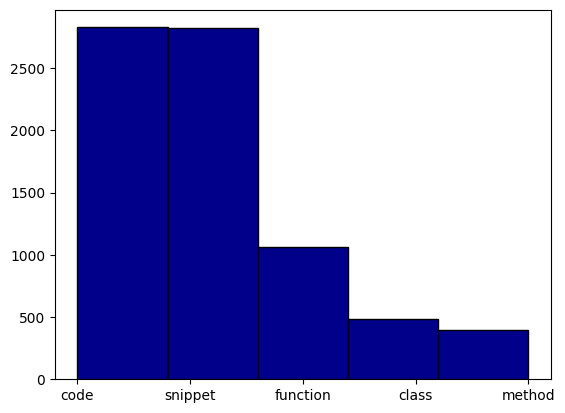

In [55]:
plt.hist(frequencies, bins=len(b1), color='darkblue', edgecolor='black')


In [89]:
print("Average:", np.nanmean(avg))
print("Standard Deviation:", np.nanstd(avg))
print("Standard Deviation:", np.nanmean(std))
print("mean gt scores:", np.mean(gt_scores))
print("std gt scores:", np.std(gt_scores))

Average: 35.61715277777778
Standard Deviation: 24.07645583498288
Standard Deviation: 10.121553175382367
mean gt scores: 6.327272727272727
std gt scores: 1.684019852915569


In [47]:
np.median(gt_scores)


[6.8]


In [48]:
counts = Counter(gt_scores)
modes = [k for k, v in counts.items() if v == max(counts.values())]
print(modes)

[6.8]


In [30]:
avg

[9.0,
 1.6899999999999995,
 0.49000000000000027,
 1.0,
 25.0,
 0.1599999999999996,
 30.805,
 0.3599999999999996,
 2.8900000000000006,
 1.9599999999999997,
 0.04000000000000007,
 2.25,
 1.4400000000000004,
 10.889999999999993,
 7.0249999999999995,
 5.0649999999999995,
 8.410000000000002,
 0.0899999999999999,
 0.20500000000000013,
 1.565,
 1.0,
 1.2200000000000002,
 1.0,
 10.240000000000002,
 6.25,
 18.49,
 2.7249999999999996,
 25.00000000000001,
 6.25,
 1.4400000000000004,
 0.6400000000000011,
 6.250000000000004,
 4.409999999999998,
 29.160000000000004,
 18.085,
 0.6400000000000011,
 6.25,
 3.2399999999999993,
 2.302449999999999,
 16.81,
 0.09000000000000043,
 6.25,
 0.49000000000000027,
 0.25,
 19.865000000000002,
 0.6399999999999997,
 3.2399999999999993,
 3.2399999999999993,
 0.04000000000000007,
 4.0,
 6.250000000000003,
 0.49000000000000027,
 0.49000000000000027,
 1.0,
 0.36000000000000065,
 1.625,
 6.25,
 0.3599999999999996,
 4.42,
 17.64,
 31.359999999999996,
 1.0,
 40.96000000000

In [17]:
from numpy import isnan
from pandas import read_csv
from sklearn.impute import SimpleImputer
# load dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/horse-colic.csv'
dataframe = read_csv(url, header=None, na_values='?')
# split into input and output elements
data2 = dataframe.values


In [18]:
data2

array([[2.00000e+00, 1.00000e+00, 5.30101e+05, ..., 0.00000e+00,
        0.00000e+00, 2.00000e+00],
       [1.00000e+00, 1.00000e+00, 5.34817e+05, ..., 0.00000e+00,
        0.00000e+00, 2.00000e+00],
       [2.00000e+00, 1.00000e+00, 5.30334e+05, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00],
       ...,
       [1.00000e+00, 1.00000e+00, 5.29386e+05, ..., 0.00000e+00,
        0.00000e+00, 2.00000e+00],
       [1.00000e+00, 1.00000e+00, 5.30612e+05, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00],
       [1.00000e+00, 1.00000e+00, 5.34618e+05, ..., 0.00000e+00,
        0.00000e+00, 2.00000e+00]])

In [19]:
ix = [i for i in range(data2.shape[1]) if i != 23]
X, y = data2[:, ix], data2[:, 23]
# print total missing
print('Missing: %d' % sum(isnan(X).flatten()))


Missing: 1605


In [24]:
X[0]

array([2.00000e+00, 1.00000e+00, 5.30101e+05, 3.85000e+01, 6.60000e+01,
       2.80000e+01, 3.00000e+00, 3.00000e+00,         nan, 2.00000e+00,
       5.00000e+00, 4.00000e+00, 4.00000e+00,         nan,         nan,
               nan, 3.00000e+00, 5.00000e+00, 4.50000e+01, 8.40000e+00,
               nan,         nan, 2.00000e+00, 1.13000e+04, 0.00000e+00,
       0.00000e+00, 2.00000e+00])

In [22]:
# define imputer
imputer = SimpleImputer(strategy='mean')
# fit on the dataset
imputer.fit(X)
# transform the dataset
Xtrans = imputer.transform(X)
# print total missing

In [25]:
Xtrans[0]

array([2.00000000e+00, 1.00000000e+00, 5.30101000e+05, 3.85000000e+01,
       6.60000000e+01, 2.80000000e+01, 3.00000000e+00, 3.00000000e+00,
       2.85375494e+00, 2.00000000e+00, 5.00000000e+00, 4.00000000e+00,
       4.00000000e+00, 1.75510204e+00, 1.58247423e+00, 4.70754717e+00,
       3.00000000e+00, 5.00000000e+00, 4.50000000e+01, 8.40000000e+00,
       2.03703704e+00, 3.01960784e+00, 2.00000000e+00, 1.13000000e+04,
       0.00000000e+00, 0.00000000e+00, 2.00000000e+00])

In [303]:
test=[2,np.nan, 3, np.nan]

In [305]:
a=sum(1 for x in test if x < 0.0 or x > 10.0)
a

0